# Cuts on the Right Handed Neutrino Decay

This notebook will contain some of the elementary cuts applied on the monoleptonic channel of the right handed neutrino decay.

The signal and the background for the process are as follows :
- Signal
    - n2n2 <br>
$p p → Z' → N_r N_r, N_r → Z v_l → j j v_l, N_r → W l → l j j$

- Background 
    - ttbar <br>
$p p → t t, t → W b, W → j j$

    - wmp <br>
$ p p → W → l v_l$

    - wpmp <br>
$ p p → W+ W- → l v_l j j$

    - zwmp <br>
$ p p → Z W, Z → j j, W → l v_l $

    - zzjj <br>
$ p p → Z Z, Z → j j $


## Hyperparameters used

### Testing parameters :
- gX = 0.1
- gN = 0.1
- Zn2 = 2.838
- Mzp = 3000 GeV
- Beam Energy = 14 TeV
- Default Jet Matching Settings

### Generation Level Cuts :
- Minimum $P_T$ of leading Lepton = 120
- Minimum $P_T$ of leading Jet = 120
- Minimum $\eta_j$ = -2
- Maximum $\eta_j$ = 2

### Analysis Level Cuts (Using Topology):
- Minimum Number of Leptons = 1
- Minimum number of Narrow Jets = 2
- Minimum Number of Fat Jets = 2

## Preprocessing

Preprocessing the python files to get the imports required and the Machine Learning to work properly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style as mpl
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.utils import shuffle
import datetime
import visualkeras
import gc

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
import tensorflow as tf
%load_ext tensorboard

In [5]:
%matplotlib inline
mpl.use('seaborn')

### Hyperparameters

In [6]:
mn2 = 750
prop_seed = 345
train_div = 0.5
back_callback_dir = "/home2/kalp_shah/neutrino/codes/ml/backup/dnn"
log_folder = "logs/dnn"
model_dir = "/home2/kalp_shah/neutrino/datasets/model/"
sig_epoch = {'test' : [], 'complete' : []}
model_max = Sequential()
max_sig = 0

2022-05-15 19:51:24.560301: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-15 19:51:25.220563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9626 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


In [7]:
!rm -rf /home2/kalp_shah/neutrino/codes/ml/backup/dnn
!rm -rf logs/dnn

## Calculating the Cross Section

The calculation of the cross section is done as follows :

$\sigma_p = \sigma_{LO} \frac{\sigma_{MGcuts}}{\sigma_{MGno-cuts}} $

In [8]:
n2n2_cs = {500  : 5.13*1e-4,
           750  : 3.83*1e-4,
           1000 : 2.42*1e-4,
           1250 : 9.56*1e-5,
           1400 : 4.74*1e-5}

In [9]:
cs_lo_k = { 'ttbar':988.57,
            'wmp'  :1.95*1e5,
            'wpwm' :124.31,
            'zwpm' :51.82,
            'n2n2' :1}

br_ratio = {'ttbar':0.67*(1-0.67)*2,
            'wmp'  :(1-0.67),
            'wpwm' :(1-0.67)*0.67*2,
            'zwpm' :0.7*(1-0.67),
            'n2n2' :1}

cs_nmg = {  'ttbar':393.30,
            'wmp'  :7.865*1e4,
            'wpwm' :74.96,
            'zwpm' :14.28,
            'n2n2' :1}

cs_mg = {   'ttbar':5.883,
            'wmp':111.5,
            'wpwm':0.944,
            'zwpm':0.2381,
            'n2n2':n2n2_cs[mn2]}

In [10]:
files = ['ttbar','wmp','wpwm','zwpm','n2n2']

# The cross sections are given in picobarn
cs_pb = []
for f in files:
    cs_pb.append((cs_lo_k[f]*br_ratio[f]*cs_mg[f])/cs_nmg[f])

cs = [i*1e3 for i in cs_pb]
cs_corr = {files[i] : cs[i] for i in range(len(files))}

In [11]:
cs_print = pd.DataFrame([cs_corr.keys(),cs_corr.values()]).T
cs_print.rename(columns = {0:'Process',1:'Cross section (fb)'}, inplace = True)

In [12]:
cs_print.style.hide_index()

Process,Cross section (fb)
ttbar,6538.845366
wmp,91227.272727
wpwm,692.256785
zwpm,199.590826
n2n2,0.383000


## Getting the Data

Finding the amount of events in storage using the following formula :

$ N_{p} = N_{files}*N_{Events-per-files} $

In [13]:
no_of_files = {'ttbar':0,
               'wmp':0,
               'wpwm':0,
               'zwpm':0,
               'n2n2':0
               }

In [14]:
df = []
for f in range(len(files)):
    con_df = []
    
    # The maximum file number 
    for i in range(1,80):
        try:
            if files[f] == 'n2n2':
                con_df.append(pd.read_csv('~/neutrino/datasets/n2n2_' + str(mn2) + '/' + files[f] + str(i) + '.csv'))
            else:
                con_df.append(pd.read_csv('~/neutrino/datasets/backgrounds/' + files[f] + str(i) + '.csv'))
            no_of_files[files[f]] += 1
        except:
            pass
    
    df.append(pd.concat(con_df,ignore_index=True))
    df[-1]['type'] = f
    
    if files[f] == "n2n2":
        df[-1]['tag'] = 1
    else:
        df[-1]['tag'] = 0

### Total Number of Files

In [15]:
red_merging = {'ttbar':98159,
               'wmp':96494,
               'wpwm':97633,
               'zwpm':81076,
               'n2n2':int(1e5)
               }

In [16]:
total_events = []

for f in range(len(files)):
    total_events.append(no_of_files[files[f]] * red_merging[files[f]])

In [17]:
nf_print = pd.DataFrame([no_of_files.keys(),total_events]).T
nf_print.rename(columns = {0:'Process',1:'Number of Events'}, inplace = True)

In [18]:
nf_print.style.hide_index()

Process,Number of Events
ttbar,6085858
wmp,5886134
wpwm,4002953
zwpm,3648420
n2n2,5000000


### Sample Output

In [19]:
df[-1].head().style.hide_index()

ptl,etal,energyl,ptj,etaj,energyj,massj,mjj,rjj,rjl,met,n21_1,n21_2,n32_1,n32_2,infl,drfl,type,tag
928.732000,0.660321,1138.670000,128.888000,-0.661150,158.918000,16.113400,93.933800,0.843245,1.791880,1154.530000,0.413587,0.437504,0.504940,0.530171,271.556000,2.370820,4,1
171.961000,-1.304190,340.146000,762.147000,0.271242,792.318000,55.740900,1519.650000,0.657866,1.588940,272.724000,0.155415,0.457475,0.572989,0.716689,1151.980000,2.243400,4,1
570.711000,-0.459771,632.103000,270.644000,0.332214,285.822000,7.777680,605.465000,2.463930,3.203950,851.541000,0.270696,0.310582,0.159234,0.665306,732.662000,2.079320,4,1
606.838000,0.224155,622.147000,1009.930000,0.653829,1236.590000,85.909400,2005.670000,3.210830,3.152860,314.435000,0.310787,0.461950,0.534193,0.575369,418.992000,2.433750,4,1
560.897000,-0.128569,565.539000,561.740000,1.096740,938.387000,81.596100,1213.140000,2.882750,1.505170,245.536000,0.204311,0.320365,0.795082,0.947598,677.436000,1.597530,4,1


### Applying Analysis Level Cuts

In [20]:
tf.random.set_seed(prop_seed)
np.random.seed(prop_seed)

In [21]:
dtset = pd.concat(df,ignore_index=True)
dtset['met'] = np.fabs(dtset['met'])

In [22]:
del(df)

In [23]:
dtset = dtset\
       [dtset['ptl'] >= 120.0]\
       [dtset['ptj'] >= 120.0]\
       [dtset['etaj'] <=  2.0]\
       [dtset['etaj'] >= -2.0]

In [24]:
dtset = shuffle(dtset)

## Machine Learning

### Making the Train and Test Dataset

The division of training and the testing set is 80:20 percent

In [25]:
test_percent = int(0.8*len(dtset))

In [26]:
x_train = dtset.T[:-2].T[:test_percent]
y_train = dtset['tag'][:test_percent]

x_test = dtset.T[:-2].T[test_percent:]
y_test = dtset['tag'][test_percent:]

In [27]:
print('The Shapes are :')
print('X Train : ',x_train.shape)
print('Y Train : ',y_train.shape)
print('X Test :  ',x_test.shape)
print('Y Test :  ',y_test.shape)

The Shapes are :
X Train :  (11815580, 17)
Y Train :  (11815580,)
X Test :   (2953896, 17)
Y Test :   (2953896,)


### Custom Functions for Saving and Backup

In [28]:
# Callbacks
backup_callback = tf.keras.callbacks.experimental.BackupAndRestore(backup_dir=back_callback_dir)

log_dir = log_folder + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [29]:
def get_significance(model,x_test,type_test,cs_corr,total_events,L):
    total_test = total_events
    tot_pred = model.predict(x_test,batch_size=131072)
    
    pred_values = tf.cast(tf.greater(tot_pred.T,0.7),'int32')
    truth_values = tf.cast(tf.equal(type_test,4),'int32')
    signal = tf.multiply(pred_values,truth_values)
    num_sig = tf.reduce_sum(signal).numpy()
    
    ns = cs_corr['n2n2']*(num_sig/(total_test[-1]))*L
    del(pred_values,truth_values,signal,num_sig)

    files = list(cs_corr.keys())
    nb = 0
    for i in range(len(cs_corr)-1):
        pred_values = tf.cast(tf.greater(tot_pred.T,0.7),'int32')
        back_values = tf.cast(tf.equal(type_test,i),'int32')
        back = tf.multiply(pred_values,back_values)
        num_back = tf.reduce_sum(back).numpy()

        nb += cs_corr[files[i]]*(num_back/(total_test[i]))*L
        del(pred_values,back_values,back,num_back)
    
    del(tot_pred)
    return ns/np.sqrt(nb)

In [30]:
class sig_callback(tf.keras.callbacks.Callback):
    def __init__(self,model,x_test,type_test,cs_corr,dtset_type,total_events):
        self.model = model
        self.type_test = type_test
        self.cs_corr = cs_corr
        self.total_events = total_events
        self.x_test = x_test
        self.dtset_type = dtset_type

    
    def on_epoch_begin(self, epoch, logs=None):
        global max_sig, model_max
        sig = get_significance(self.model,self.x_test,self.type_test,
                              self.cs_corr,self.total_events,3000)
        print('The '+ self.dtset_type +' significance is : ',sig)
        
        if epoch==0:
            model_max = self.model
            max_sig = sig
        
        elif self.dtset_type == 'test' and max_sig < sig:
            model_max = tf.keras.models.clone_model(self.model)
            
            max_sig = sig
            
        elif self.dtset_type == 'complete': 
            gc.collect()
            
        sig_epoch[self.dtset_type].append(sig)

### The DNN Model

In [31]:
model = Sequential()
input_shape = x_train.shape

model.add(Dense(30,activation = 'relu',input_dim = input_shape[1]))
model.add(BatchNormalization())
model.add(Dense(60,activation = 'relu',input_dim = 30))
model.add(BatchNormalization())
model.add(Dense(60,activation = 'relu',input_dim = 60))
model.add(BatchNormalization())
model.add(Dense(40,activation = 'relu',input_dim = 60))
model.add(BatchNormalization())
model.add(Dense(40,activation = 'relu',input_dim = 40))
model.add(BatchNormalization())
model.add(Dense(12,activation = 'relu',input_dim = 40))
model.add(BatchNormalization())
model.add(Dense(8,activation = 'relu',input_dim = 12))
model.add(BatchNormalization())
model.add(Dense(1,activation = 'sigmoid',input_dim = 8))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

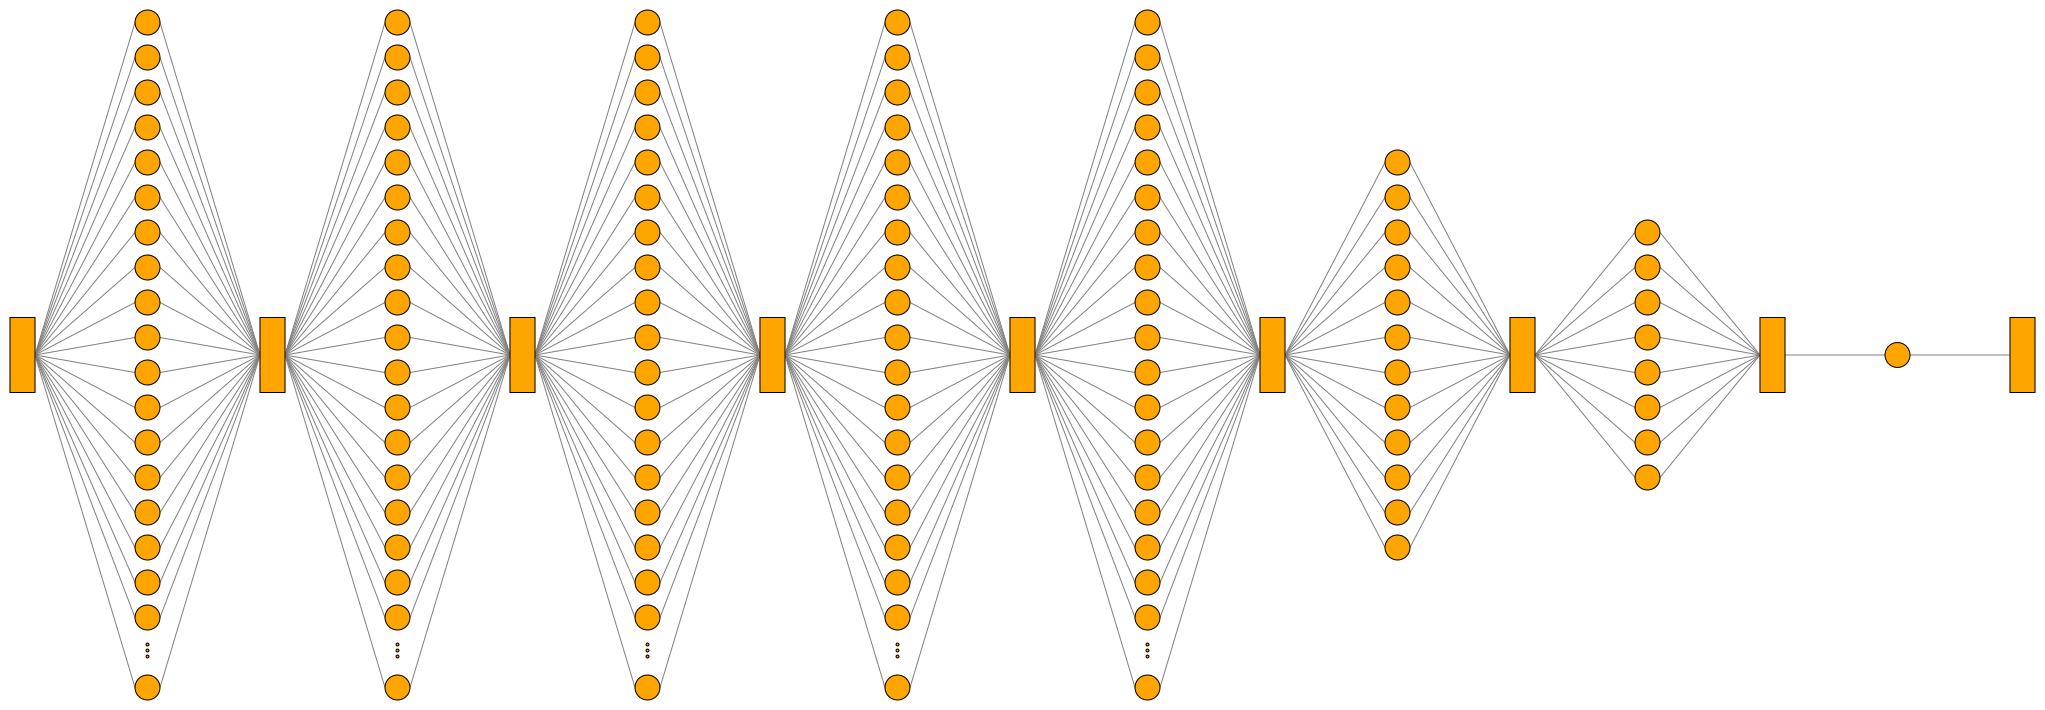

In [32]:
visualkeras.graph_view(model,node_size=25,layer_spacing=100,ellipsize_after=20)

### Learning

In [33]:
try:
    model.fit(x_train,y_train,
              epochs=2500,batch_size=131072,
              class_weight={0:0.999,1:0.025},
              callbacks=[backup_callback,tensorboard_callback],
              validation_split=0.2
              )

except:
    pass

Epoch 1/2500
73/73 [==============================] - 5s 38ms/step - loss: 0.2489 - accuracy: 0.9320 - val_loss: 0.4170 - val_accuracy: 0.8443
Epoch 2/2500
73/73 [==============================] - 2s 25ms/step - loss: 0.1304 - accuracy: 0.9455 - val_loss: 0.2048 - val_accuracy: 0.9404
Epoch 3/2500
73/73 [==============================] - 2s 28ms/step - loss: 0.0820 - accuracy: 0.9332 - val_loss: 0.2416 - val_accuracy: 0.8998
Epoch 4/2500
73/73 [==============================] - 2s 25ms/step - loss: 0.0584 - accuracy: 0.9215 - val_loss: 0.2833 - val_accuracy: 0.8820
Epoch 5/2500
73/73 [==============================] - 2s 24ms/step - loss: 0.0447 - accuracy: 0.9113 - val_loss: 0.2888 - val_accuracy: 0.8835
Epoch 6/2500
73/73 [==============================] - 2s 24ms/step - loss: 0.0359 - accuracy: 0.9024 - val_loss: 0.3066 - val_accuracy: 0.8788
Epoch 7/2500
73/73 [==============================] - 2s 24ms/step - loss: 0.0297 - accuracy: 0.8972 - val_loss: 0.3402 - val_accuracy: 0.8639

### Analysis

Checking the data overfitting using test set and cheking if the accuracy is similar to the training and the validation set

In [34]:
model.evaluate(x_test,y_test,batch_size = 4096,verbose=True)

722/722 [==============================] - 2s 2ms/step - loss: 0.1674 - accuracy: 0.9374


[0.1673528552055359, 0.9374097585678101]

In [35]:
pred_set = dtset.copy()
pred_set['pred'] = model.predict(pred_set.T[:-2].T,batch_size = 4096,verbose=True)

3606/3606 [==============================] - 6s 1ms/step


In [36]:
prob_sig = 0.999
L = 3000

In [37]:
print('Correctly identified signal (True Positive)     : ',len(pred_set[pred_set['pred'] >= prob_sig][pred_set['tag'] == 1]))
print('Falsely identified signal (Flase Positive)      : ',len(pred_set[pred_set['pred'] >= prob_sig][pred_set['tag'] == 0]))
print('Correctly identified background (True Negative) : ',len(pred_set[pred_set['pred'] < prob_sig][pred_set['tag'] == 0]))
print('Falsely identified background (False Negative)  : ',len(pred_set[pred_set['pred'] < prob_sig][pred_set['tag'] == 1]))

Correctly identified signal (True Positive)     :  1495783
Falsely identified signal (Flase Positive)      :  517
Correctly identified background (True Negative) :  10855262
Falsely identified background (False Negative)  :  2417914


In [38]:
print('Thus, the rate of correct signal prediction is : ',len(pred_set[pred_set['pred'] >= prob_sig][pred_set['tag'] == 1])/(len(pred_set[pred_set['pred'] >= prob_sig])))

Thus, the rate of correct signal prediction is :  0.9996544810532647


In [39]:
ns = cs_corr['n2n2']*(len(pred_set[pred_set['pred'] >= prob_sig][pred_set['tag'] == 1])/(total_events[-1]))*L
print('n2n2',(len(pred_set[pred_set['pred'] >= prob_sig][pred_set['tag'] == 1])),cs_corr['n2n2'])
nb = 0

for i in range(len(files)-1):
    nb += cs_corr[files[i]]*(len(pred_set[pred_set['pred'] >= prob_sig][pred_set['tag'] == 0][pred_set['type'] == i])/((total_events[i])))*L
    print(files[i],len(pred_set[pred_set['pred'] >= prob_sig][pred_set['tag'] == 0][pred_set['type'] == i]),cs_corr[files[i]])

n2n2 1495783 0.38300000000000006
ttbar 18 6538.845366086956
wmp 41 91227.27272727272
wpwm 199 692.2567850586979
zwpm 259 199.5908264705882


In [40]:
print('The number of signal is :', ns)
print('The number of background is :', nb)
print('The significance is :',ns/np.sqrt(nb))

The number of signal is : 343.7309334000001
The number of background is : 2110.1060329582433
The significance is : 7.4828403217746935


In [41]:
model.save(model_dir + "dnn" + str(mn2))

2022-05-15 21:05:35.902067: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home2/kalp_shah/neutrino/datasets/model/dnn750/assets


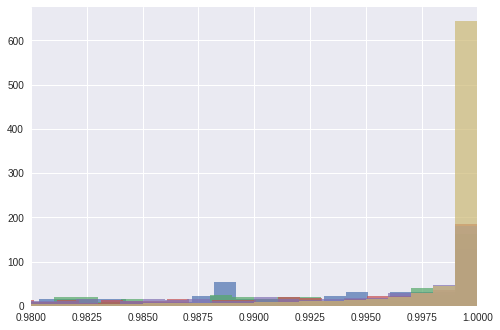

In [42]:
for i in range(len(files)):
    data = pred_set[pred_set["type"] == i][pred_set["pred"]>=0.9]["pred"].values
    plt.hist(data,alpha=0.7,bins=100,density=True)

plt.xlim([0.98,1])
plt.show()